Part of this is reproduction from: https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53

$$y \sim \mathcal{N} (\alpha + \beta X, \sigma)$$

intercept α and a gradient β, and our data is distributed about this straight line with Gaussian noise of standard deviation σ.

In [1]:
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
multiprocessing.set_start_method("fork")

sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

Text(0.5, 1.0, 'Scatter Plot of Data')

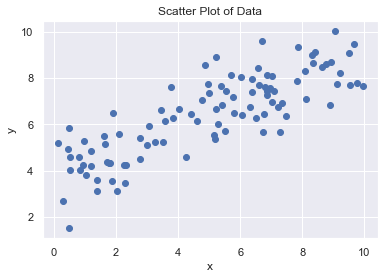

In [2]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')

In [3]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.


Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  7.8e-3    0.2   3.43   3.71   3.84   3.99   4.25    689    1.0
beta    0.52  1.4e-3   0.04   0.45   0.49   0.52   0.54   0.59    695   1.01
sigma   1.02  2.2e-3   0.07   0.89   0.97   1.02   1.06   1.17   1055    1.0
lp__  -50.67    0.05    1.2 -53.74 -51.18 -50.38 -49.82 -49.27    660   1.01

Samples were drawn using NUTS at Thu Dec 17 17:24:31 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [4]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

(-0.5, 10.5)

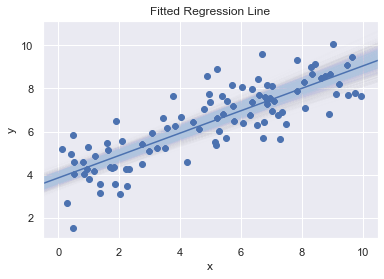

In [5]:
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
for _ in range(1000):
  alpha_p, beta_p = np.random.choice(alpha), np.random.choice(beta)
  plt.plot(x_plot, alpha_p + beta_p * x_plot, color='lightsteelblue',
           alpha=0.005 )

# Plot mean regression line  
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)

In [6]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel('samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    plt.title('Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    plt.xlabel(param_name)
    plt.ylabel('density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    plt.tight_layout()
    plt.legend()

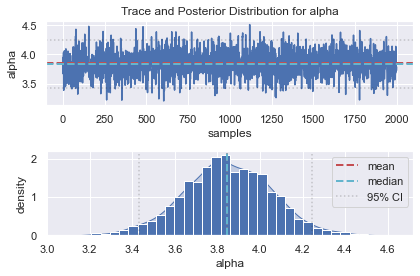

In [7]:
plot_trace(alpha, 'alpha') 

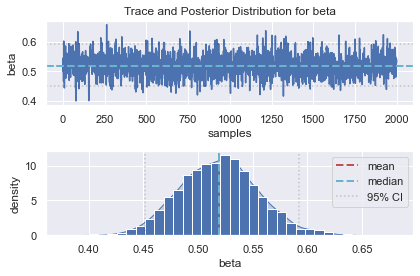

In [8]:
 plot_trace(beta, 'beta')

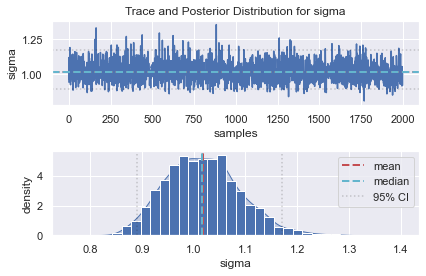

In [9]:
 plot_trace(sigma, 'sigma')

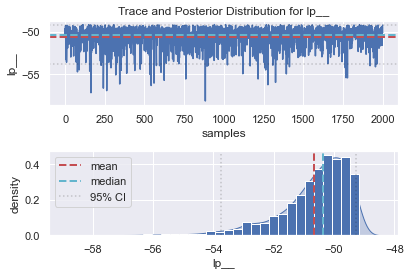

In [10]:
plot_trace(lp, 'lp__')

In [ ]:
https://mc-stan.org/docs/2_23/stan-users-guide/example-decision-analysis.html
https://mc-stan.org/docs/2_25/stan-users-guide/examples.html

In [101]:
model = """
functions {
    real eu(real x0, real x1, real p, int y, real alpha) {
    vector[2] v;
    vector[2] p_choice;
    int c;
    v[1] = p * pow(x0, 1-alpha);
    v[2] = (1- p) * pow(x1, 1-alpha);
    p_choice = softmax(v);
    c = y+1;
    return p_choice[c];
  }
}
data {
    int<lower=0> N;
    vector[N] x0;
    vector[N] x1;
    vector[N] p;
    int<lower=0,upper=1> y[N];
}
parameters {
    real<lower=-1, upper=1>alpha;
}
model {
    for (i in 1:N)
        target += log(eu(x0[i], x1[i], p[i], y[i], alpha));
}
"""

In [102]:
from scipy.special import expit

In [103]:
N = 100
p = np.random.random(size=N)
x0 = np.random.random(size=N)
x1 = np.random.random(size=N)

risk = 0.3
inv_tmp = 0.1

v0 = p * x0**(1-risk)
v1 = p * x1**(1-risk)
delta = v1 - v0
p_choice1 = expit(delta)

y = np.zeros(N, dtype=int)
y[:] = p_choice1 > np.random.random(size=N)


data = {'N': N, 'x0': x1, 'x1': x1, 'p':p, 'y': list(y)}

In [ ]:
# Compile the model
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4328c65a1528dd4038c1e21f566b0c3 NOW.


In [ ]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
print(fit)